In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from tqdm import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Feature columns
feature_cols = [
    "year",
    "membership_year",
    "is_household",
    "vehicle_count",
    "vehicle_age_mean",
    "beløp",
    "gave_feedback",
    "mean_feedback",
    "age",
    "gender",
    "sentralitetsindex",
]

# Load the examples
train_examples = torch.load("all/train_examples.pt")
val_examples = torch.load("all/val_examples.pt")

In [3]:
# 4. Dataset & DataLoader
class ChurnDataset(Dataset):
    def __init__(self, examples):
        self.examples = examples

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        seq, length, label = self.examples[idx]
        return seq, length, label


def collate_fn(batch):
    seqs, lengths, labels = zip(*batch)
    # pad to the max seq‐len in the batch
    seqs_padded = pad_sequence(seqs, batch_first=True)  # [B, T, F]
    lengths = torch.tensor(lengths, dtype=torch.long)  # [B]
    labels = torch.tensor(labels, dtype=torch.long)  # [B]
    # build an attention mask: True == padding
    max_len = seqs_padded.size(1)
    # shape [B, T]: for each example, positions >= length are padding
    attn_mask = torch.arange(max_len, device=lengths.device).unsqueeze(0).expand(
        len(lengths), -1
    ) >= lengths.unsqueeze(1)
    return (
        seqs_padded.to(device),
        lengths.to(device),
        attn_mask.to(device),
        labels.to(device),
    )


train_ds = ChurnDataset(train_examples)
val_ds = ChurnDataset(val_examples)
train_loader = DataLoader(train_ds, batch_size=512, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=512, shuffle=False, collate_fn=collate_fn)

In [4]:
# 5. Model
torch.manual_seed(42)


class InformerClassifier(nn.Module):
    def __init__(self, input_size, d_model, n_heads, e_layers, d_ff, num_classes):
        super().__init__()
        self.embedding = nn.Linear(input_size, d_model)
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_ff,
            batch_first=True,
            norm_first=True,
        )
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=e_layers)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x, lengths, attn_mask):
        # [B, T, F] → [B, T, d_model]
        x = self.embedding(x)
        # In PyTorch, TransformerEncoder expects mask == True for places NOT to attend (i.e., padding)
        x = self.encoder(x, src_key_padding_mask=attn_mask)
        # Use the last **non-padded** token representation
        batch_size = x.size(0)
        last_valid_indices = lengths - 1  # [B]
        last_token_repr = x[torch.arange(batch_size), last_valid_indices]
        out = self.fc(last_token_repr)
        return out


# Instantiate model
input_size = len(feature_cols)
d_model = 64  # Embedding size (similar to hidden_size)
n_heads = 4  # Attention heads
e_layers = 2  # Encoder layers
d_ff = 256  # Feed-forward dimension
num_classes = 3

model = InformerClassifier(
    input_size, d_model, n_heads, e_layers, d_ff, num_classes
).to(device)

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

/root/nielsen/informer-test/.venv/lib/python3.13/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [5]:
import wandb

num_epochs = 50

wandb.init(project="churn", name="informer")


# 6. Training & Evaluation
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct, total = 0, 0, 0
    loop = tqdm(loader, desc="Train")
    for seqs, lengths, attn_mask, labels in loop:
        optimizer.zero_grad()
        outputs = model(seqs, lengths, attn_mask)  # <-- add attn_mask here
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        loop.set_postfix(loss=loss.item(), acc=correct / total)
    return total_loss / total, correct / total


def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    loop = tqdm(loader, desc="Val")
    with torch.no_grad():
        for seqs, lengths, attn_mask, labels in loop:
            outputs = model(seqs, lengths, attn_mask)  # <-- add attn_mask here
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            loop.set_postfix(loss=loss.item(), acc=correct / total)
    return total_loss / total, correct / total


# Run training
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = eval_epoch(model, val_loader, criterion)
    print(
        f"Epoch {epoch:>2d}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f} | val_loss={val_loss:.4f}, val_acc={val_acc:.4f}"
    )

    # Log to wandb
    wandb.log(
        {
            "epoch": epoch,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc,
        }
    )

wandb.finish()

wandb: Currently logged in as: junta to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Val: 100%|██████████| 147/147 [00:02<00:00, 62.77it/s, acc=0.532, loss=0.877]


Epoch  1: train_loss=0.9566, train_acc=0.5182 | val_loss=0.9313, val_acc=0.5321


Val: 100%|██████████| 147/147 [00:02<00:00, 62.76it/s, acc=0.546, loss=0.843]


Epoch  2: train_loss=0.9211, train_acc=0.5350 | val_loss=0.9020, val_acc=0.5460


Val: 100%|██████████| 147/147 [00:02<00:00, 62.41it/s, acc=0.547, loss=0.833]


Epoch  3: train_loss=0.9065, train_acc=0.5422 | val_loss=0.8927, val_acc=0.5472


Val: 100%|██████████| 147/147 [00:02<00:00, 61.51it/s, acc=0.551, loss=0.841]


Epoch  4: train_loss=0.9010, train_acc=0.5452 | val_loss=0.8944, val_acc=0.5509


Val: 100%|██████████| 147/147 [00:02<00:00, 64.83it/s, acc=0.552, loss=0.826]


Epoch  5: train_loss=0.8964, train_acc=0.5471 | val_loss=0.8917, val_acc=0.5519


Val: 100%|██████████| 147/147 [00:02<00:00, 63.54it/s, acc=0.55, loss=0.831] 


Epoch  6: train_loss=0.8937, train_acc=0.5480 | val_loss=0.8909, val_acc=0.5499


Val: 100%|██████████| 147/147 [00:02<00:00, 63.25it/s, acc=0.554, loss=0.821]


Epoch  7: train_loss=0.8919, train_acc=0.5482 | val_loss=0.8837, val_acc=0.5538


Val: 100%|██████████| 147/147 [00:02<00:00, 62.75it/s, acc=0.551, loss=0.827]


Epoch  8: train_loss=0.8909, train_acc=0.5479 | val_loss=0.8841, val_acc=0.5509


Val: 100%|██████████| 147/147 [00:03<00:00, 43.95it/s, acc=0.552, loss=0.833]


Epoch  9: train_loss=0.8891, train_acc=0.5498 | val_loss=0.8860, val_acc=0.5517


Val: 100%|██████████| 147/147 [00:02<00:00, 61.53it/s, acc=0.554, loss=0.823]


Epoch 10: train_loss=0.8872, train_acc=0.5497 | val_loss=0.8831, val_acc=0.5537


Val: 100%|██████████| 147/147 [00:02<00:00, 62.83it/s, acc=0.55, loss=0.825] 


Epoch 11: train_loss=0.8868, train_acc=0.5499 | val_loss=0.8846, val_acc=0.5503


Val: 100%|██████████| 147/147 [00:02<00:00, 63.59it/s, acc=0.551, loss=0.817]


Epoch 12: train_loss=0.8857, train_acc=0.5502 | val_loss=0.8848, val_acc=0.5510


Val: 100%|██████████| 147/147 [00:03<00:00, 45.15it/s, acc=0.555, loss=0.814]


Epoch 13: train_loss=0.8848, train_acc=0.5510 | val_loss=0.8794, val_acc=0.5549


Val: 100%|██████████| 147/147 [00:02<00:00, 63.11it/s, acc=0.554, loss=0.826]


Epoch 14: train_loss=0.8839, train_acc=0.5510 | val_loss=0.8849, val_acc=0.5544


Val: 100%|██████████| 147/147 [00:02<00:00, 62.24it/s, acc=0.556, loss=0.81] 


Epoch 15: train_loss=0.8839, train_acc=0.5509 | val_loss=0.8795, val_acc=0.5556


Val: 100%|██████████| 147/147 [00:02<00:00, 62.87it/s, acc=0.553, loss=0.818]


Epoch 16: train_loss=0.8826, train_acc=0.5510 | val_loss=0.8806, val_acc=0.5535


Val: 100%|██████████| 147/147 [00:03<00:00, 39.45it/s, acc=0.556, loss=0.818]


Epoch 17: train_loss=0.8818, train_acc=0.5516 | val_loss=0.8788, val_acc=0.5555


Val: 100%|██████████| 147/147 [00:02<00:00, 61.77it/s, acc=0.554, loss=0.812]


Epoch 18: train_loss=0.8817, train_acc=0.5511 | val_loss=0.8777, val_acc=0.5543


Val: 100%|██████████| 147/147 [00:02<00:00, 61.59it/s, acc=0.552, loss=0.822]


Epoch 19: train_loss=0.8814, train_acc=0.5524 | val_loss=0.8794, val_acc=0.5523


Val: 100%|██████████| 147/147 [00:03<00:00, 44.84it/s, acc=0.557, loss=0.824]


Epoch 20: train_loss=0.8807, train_acc=0.5520 | val_loss=0.8767, val_acc=0.5565


Val: 100%|██████████| 147/147 [00:03<00:00, 45.02it/s, acc=0.553, loss=0.826]


Epoch 21: train_loss=0.8804, train_acc=0.5523 | val_loss=0.8812, val_acc=0.5529


Val: 100%|██████████| 147/147 [00:02<00:00, 65.41it/s, acc=0.555, loss=0.819]


Epoch 22: train_loss=0.8803, train_acc=0.5526 | val_loss=0.8792, val_acc=0.5545


Val: 100%|██████████| 147/147 [00:02<00:00, 63.73it/s, acc=0.556, loss=0.82] 


Epoch 23: train_loss=0.8796, train_acc=0.5521 | val_loss=0.8784, val_acc=0.5564


Val: 100%|██████████| 147/147 [00:03<00:00, 48.52it/s, acc=0.555, loss=0.819]


Epoch 24: train_loss=0.8793, train_acc=0.5531 | val_loss=0.8771, val_acc=0.5547


Val: 100%|██████████| 147/147 [00:02<00:00, 61.53it/s, acc=0.555, loss=0.82] 


Epoch 25: train_loss=0.8787, train_acc=0.5526 | val_loss=0.8769, val_acc=0.5546


Val: 100%|██████████| 147/147 [00:02<00:00, 60.45it/s, acc=0.556, loss=0.818]


Epoch 26: train_loss=0.8785, train_acc=0.5526 | val_loss=0.8758, val_acc=0.5562


Val: 100%|██████████| 147/147 [00:02<00:00, 63.18it/s, acc=0.557, loss=0.828]


Epoch 27: train_loss=0.8784, train_acc=0.5529 | val_loss=0.8799, val_acc=0.5570


Val: 100%|██████████| 147/147 [00:02<00:00, 59.86it/s, acc=0.556, loss=0.82] 


Epoch 28: train_loss=0.8780, train_acc=0.5528 | val_loss=0.8768, val_acc=0.5564


Val: 100%|██████████| 147/147 [00:02<00:00, 63.81it/s, acc=0.555, loss=0.82] 


Epoch 29: train_loss=0.8779, train_acc=0.5533 | val_loss=0.8776, val_acc=0.5546


Val: 100%|██████████| 147/147 [00:02<00:00, 61.49it/s, acc=0.555, loss=0.817]


Epoch 30: train_loss=0.8769, train_acc=0.5533 | val_loss=0.8794, val_acc=0.5550


Val: 100%|██████████| 147/147 [00:02<00:00, 62.63it/s, acc=0.553, loss=0.818]


Epoch 31: train_loss=0.8768, train_acc=0.5529 | val_loss=0.8769, val_acc=0.5533


Val: 100%|██████████| 147/147 [00:02<00:00, 62.72it/s, acc=0.557, loss=0.813]


Epoch 32: train_loss=0.8768, train_acc=0.5543 | val_loss=0.8754, val_acc=0.5571


Val: 100%|██████████| 147/147 [00:02<00:00, 64.36it/s, acc=0.557, loss=0.819]


Epoch 33: train_loss=0.8767, train_acc=0.5536 | val_loss=0.8747, val_acc=0.5567


Val: 100%|██████████| 147/147 [00:02<00:00, 62.37it/s, acc=0.555, loss=0.819]


Epoch 34: train_loss=0.8761, train_acc=0.5541 | val_loss=0.8761, val_acc=0.5554


Val: 100%|██████████| 147/147 [00:02<00:00, 61.78it/s, acc=0.558, loss=0.819]


Epoch 35: train_loss=0.8758, train_acc=0.5539 | val_loss=0.8757, val_acc=0.5581


Val: 100%|██████████| 147/147 [00:03<00:00, 45.25it/s, acc=0.557, loss=0.825]


Epoch 36: train_loss=0.8760, train_acc=0.5543 | val_loss=0.8754, val_acc=0.5565


Val: 100%|██████████| 147/147 [00:02<00:00, 61.80it/s, acc=0.556, loss=0.819]


Epoch 37: train_loss=0.8759, train_acc=0.5536 | val_loss=0.8753, val_acc=0.5560


Val: 100%|██████████| 147/147 [00:02<00:00, 61.43it/s, acc=0.556, loss=0.828]


Epoch 38: train_loss=0.8755, train_acc=0.5543 | val_loss=0.8783, val_acc=0.5555


Val: 100%|██████████| 147/147 [00:02<00:00, 62.70it/s, acc=0.557, loss=0.833]


Epoch 39: train_loss=0.8755, train_acc=0.5542 | val_loss=0.8783, val_acc=0.5573


Val: 100%|██████████| 147/147 [00:03<00:00, 44.43it/s, acc=0.553, loss=0.825]


Epoch 40: train_loss=0.8752, train_acc=0.5549 | val_loss=0.8777, val_acc=0.5527


Val: 100%|██████████| 147/147 [00:02<00:00, 62.75it/s, acc=0.556, loss=0.821]


Epoch 41: train_loss=0.8754, train_acc=0.5540 | val_loss=0.8754, val_acc=0.5559


Val: 100%|██████████| 147/147 [00:02<00:00, 63.55it/s, acc=0.556, loss=0.821]


Epoch 42: train_loss=0.8750, train_acc=0.5547 | val_loss=0.8743, val_acc=0.5555


Val: 100%|██████████| 147/147 [00:02<00:00, 61.22it/s, acc=0.557, loss=0.827]


Epoch 43: train_loss=0.8749, train_acc=0.5551 | val_loss=0.8735, val_acc=0.5570


Val: 100%|██████████| 147/147 [00:02<00:00, 61.81it/s, acc=0.558, loss=0.813]


Epoch 44: train_loss=0.8741, train_acc=0.5552 | val_loss=0.8733, val_acc=0.5576


Val: 100%|██████████| 147/147 [00:02<00:00, 63.01it/s, acc=0.554, loss=0.827]


Epoch 45: train_loss=0.8745, train_acc=0.5548 | val_loss=0.8739, val_acc=0.5538


Val: 100%|██████████| 147/147 [00:02<00:00, 68.97it/s, acc=0.557, loss=0.824]


Epoch 46: train_loss=0.8740, train_acc=0.5553 | val_loss=0.8738, val_acc=0.5565


Val: 100%|██████████| 147/147 [00:02<00:00, 61.04it/s, acc=0.557, loss=0.825]


Epoch 47: train_loss=0.8732, train_acc=0.5554 | val_loss=0.8809, val_acc=0.5565


Val: 100%|██████████| 147/147 [00:02<00:00, 52.03it/s, acc=0.554, loss=0.836]


Epoch 48: train_loss=0.8738, train_acc=0.5557 | val_loss=0.8800, val_acc=0.5536


Val: 100%|██████████| 147/147 [00:03<00:00, 44.23it/s, acc=0.558, loss=0.824]


Epoch 49: train_loss=0.8737, train_acc=0.5549 | val_loss=0.8736, val_acc=0.5578


Val: 100%|██████████| 147/147 [00:02<00:00, 62.75it/s, acc=0.556, loss=0.827]
wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch 50: train_loss=0.8737, train_acc=0.5547 | val_loss=0.8795, val_acc=0.5557


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_accuracy,▁▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇██████████████
train_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▅▆▆▇▆▆▇▆▇▇▇▇▇▆█▇▇█▇██▇▇█▇██▇█▇▇▇█▇██▇▇
val_loss,█▄▃▄▃▂▂▂▂▂▂▂▂▂▁▁▂▂▂▁▁▂▁▁▂▁▁▁▁▁▂▂▁▁▁▁▁▂▂▂
epoch,50
train_accuracy,0.55472
train_loss,0.87366
val_accuracy,0.55569
val_loss,0.87949


ROC AUC Score (OvR): 0.7433

Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.77      0.58     21127
           1       0.68      0.59      0.63     34706
           2       0.48      0.26      0.34     19394

    accuracy                           0.56     75227
   macro avg       0.54      0.54      0.52     75227
weighted avg       0.57      0.56      0.54     75227



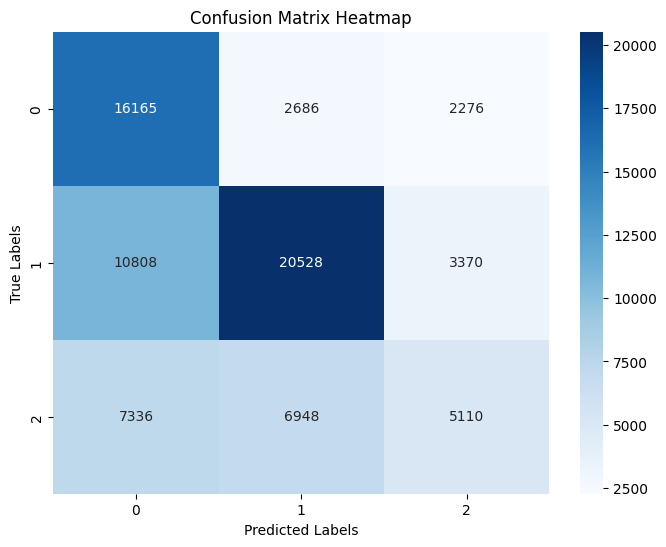

In [6]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Collect all true labels and predicted probabilities
model.eval()
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for seqs, lengths, attn_mask, labels in tqdm(
        val_loader, desc="Collecting predictions"
    ):
        outputs = model(seqs, lengths, attn_mask)  # <-- add attn_mask here
        probs = torch.softmax(outputs, dim=1)
        preds = outputs.argmax(dim=1)

        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

all_labels = np.concatenate(all_labels)
all_preds = np.concatenate(all_preds)
all_probs = np.concatenate(all_probs)

# 2. ROC AUC Score (one-vs-rest for multiclass)
roc_auc = roc_auc_score(all_labels, all_probs, multi_class="ovr")
print(f"ROC AUC Score (OvR): {roc_auc:.4f}")

# 3. Classification Report
report = classification_report(all_labels, all_preds)
print("\nClassification Report:\n", report)

# 4. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()